# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4

**Warning 1**: You have 2 weeks for this assignemnt.  **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [3]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, r2_score
from statsmodels.tools.eval_measures import rmse
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hand. 

### Task 1 <a id="task1"></a> (0.5 points)

Here you should implement the function `H()` which calculates impurity criterion. We will be training regression tree, and will take mean absolute deviation as impurity criterion.

* You cannot use loops
* If `y` is empty, the function should return 0

In [2]:
def H(y):
    """
    Calculate impurity criterion
    
    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    if len(y) == 0:
        return 0.0

    mean = sum(y) / len(y)
    impurity = np.sum(np.abs(y - mean)) / len(y)
    return impurity

In [3]:
# Test the function
assert np.allclose(H(np.array([4, 2, 2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote: 
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [4]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node 
    y : ndarray
        array of target values in the node 
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """   
    R = X[:, j]
    y_l = y[R <= t]
    y_r = y[R > t]
    impurity_left = H(y_l)
    impurity_right = H(y_r)
    Q = impurity_left * len(y_l) / len(y)  + \
        impurity_right * len(y_r) / len(y)
    return Q

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Also, please add `min_samples_leaf` parameter to your class

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [5]:
class Node(object):
    """
    Class for a decision tree node.
    
    Parameters
    ----------
    right : Node() or None
        Right child
    right : Node() or None
        Left child
    threshold: float
        
    column: int
        
    depth: int
        
    prediction: float
        prediction of the target value in the node 
        (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """    
    def __init__(self):        
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None
        
    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'. \
            format(self.column, self.threshold, self.prediction)
        return node_desc

In [6]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """ 
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf

            
    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node. 
        Try all features and thresholds. 
        
        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels. 
            
        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child. 
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child. 
        """
        
        # To store best split parameters
        best_split_column = None
        best_threshold = None
        # without splitting
        best_cost = H(y)
        for feature  in range(X.shape[1]):
            x_split_col = X[:, feature]
            for split_threshold in range(0, len(x_split_col)):
                curr_threshold = x_split_col[split_threshold]
                q_cost = Q(X, y , feature, curr_threshold)
                if best_cost > q_cost:
                    best_threshold = curr_threshold
                    best_split_column = feature
                    best_cost = q_cost

        if best_cost == H(y):
            return None, None, None, None, None, None
        x_column = X[:, best_split_column]
        x_left = X[x_column <= best_threshold, :]
        y_left = y[x_column <= best_threshold]
        x_right = X[x_column > best_threshold, :]
        y_right = y[x_column > best_threshold]
        return best_split_column, best_threshold, x_left, y_left, x_right, y_right
    
    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth`, 
        `min_samples_split` parameters for a given node. 
        
        Parameters
        ----------
        node : Node, 
            
        y : ndarray, shape (n_objects, )
            Object labels. 
            
        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:    
            return True
        if len(y) < self.min_samples_split:   
            return True
        return False
        
    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects 
        y : ndarray, shape (n_objects)
            Labels
        """
        
        if self.is_terminal(node, y):
            node.is_terminal = True
            return


        best_split_column, best_threshold, x_left, y_left, x_right, y_right = self.best_split(X, y)

        if best_split_column is None:
            node.is_terminal = True
            return

        if len(x_left) < self.min_samples_leaf or len(x_right) < self.min_samples_leaf:  # min_samples_leaf check
            node.is_terminal = True
            return

        node.column = best_split_column
        node.threshold = best_threshold

        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.prediction = np.mean(y_left)

        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.prediction = np.mean(y_right)

        self.grow_tree(node.left, x_left, y_left)
        self.grow_tree(node.right, x_right, y_right)

    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.
            
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True
        self.n_features_in_ = X.shape[1]
        # Initialize the tree (root node)
        self.tree_ = Node()                             
        self.tree_.depth = 0
        self.tree_.prediction = np.mean(y)
        
        # Grow the tree
        self.grow_tree(self.tree_, X, y)
        return self        
    
    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get 
            predictions of the proper child
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """
        if node.is_terminal:
            return node.prediction
        if x[node.column] > node.threshold:
            y_pred = self.get_prediction(node.right, x)
        else:
            y_pred = self.get_prediction(node.left, x)
        return y_pred
    
    def predict(self, X):
        """ 
        Get prediction for each object in X
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        
        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [7]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($75\%$) and test ($25\%$). Fit Decision Tree of depth 1 and make the following plot:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model 

Best split column number -  5
Best threshold -  6.794
Left node prediction 19.696091205211726
Right node prediction 35.93333333333333


Text(0.5, 1.0, 'Decision tree (max_depth=1)')

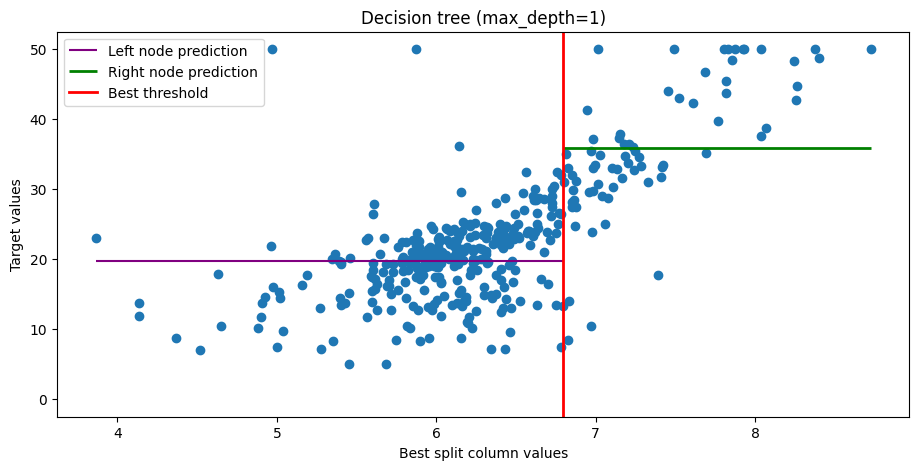

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import load_boston

boston_dataset = load_boston()
X = boston_dataset.data
y = boston_dataset.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11)
decision_tree = MyDecisionTreeRegressor(max_depth=1)
decision_tree.fit(X_train, y_train)
y_predicted = decision_tree.predict(X_test)
x_column = X_train[:,decision_tree.tree_.column]

left_prediction = decision_tree.tree_.left.prediction
right_prediction = decision_tree.tree_.right.prediction
best_threshold = decision_tree.tree_.threshold

print('Best split column number - ', decision_tree.tree_.column)
print('Best threshold - ', best_threshold)
print('Left node prediction', left_prediction)
print('Right node prediction', right_prediction)

plt.scatter(x_column, y_train)
plt.xlabel('Best split column values')
plt.ylabel('Target values')
plt.hlines(left_prediction, xmin=x_column.min(), xmax=best_threshold, color='purple', label='Left node prediction')
plt.hlines(right_prediction, xmin=best_threshold, xmax=x_column.max(), linewidth=2, color='green', label='Right node prediction')
plt.axline((best_threshold, 0), (best_threshold, y_train.max()), linewidth=2, color='r', label='Best threshold')
plt.legend()
plt.title('Decision tree (max_depth=1)')

### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset. 
- Use `GridSearchCV` to find the best hyperparameters among [`max_depth`, `min_samples_leaf`] on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset. 
- Report `MAE` on test dataset and hyperparameters of the best estimator. 

In [9]:
from sklearn.metrics import mean_absolute_error

clf = MyDecisionTreeRegressor()
parameters = {'max_depth':[1, 3, 5, 7, 9],
              'min_samples_leaf':[1, 5, 10]}

decision_model = GridSearchCV(clf,
                  parameters,
                  scoring='neg_mean_absolute_error',
                  cv=5)
decision_model.fit(X_train, y_train)
print(decision_model.best_params_)
pred = decision_model.predict(X_test)
print('MAE score: ', mean_absolute_error(y_test, pred))

{'max_depth': 5, 'min_samples_leaf': 5}
MAE score:  3.0551652382894425


### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points
    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized. 

Алгоритм:
n_iter раз случайным образом формируем выборку размера, равного размеру
первоначальной выборки, состоящую из элементов первоначальной выборки, которые
могут повторяться, формируем oob - все элементы, которые не вошли в полученную
случайную выборку. Обучаем модель на случайной выборке, делаем предсказание.
Полученное предсказание сохраняем в массив, где строка- это номер итерации,
а столбец - это индекс элемента из oob. Далее считаем bias и variance по формулам.

In [10]:
def get_bias_variance(estimator, x, y, n_iter):
    """ 
    Calculate bias and variance of the `estimator`. 
    Using a given dataset and bootstrap with `n_iter` samples. 

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in 
    Returns
    -------
    bias2 : float, 
        Estiamted squared bias
    variance : float, 
        Estiamted variance
    """

    predictions_for_indexes = np.empty(shape=(n_iter, x.shape[0]))
    predictions_for_indexes.fill(np.nan)
    for i in range(n_iter):
        np.random.seed(i)
        indexes = np.arange(x.shape[0]).tolist()
        random_indexes = np.random.choice(indexes, len(indexes))
        oob_index = list(set(indexes) - set(random_indexes))
        x_sample = x[random_indexes, :]
        y_sample = y[random_indexes]
        estimator.fit(x_sample, y_sample)
        x_pred_sample = x[oob_index, :]
        prediction = estimator.predict(x_pred_sample)
        predictions_for_indexes[i, oob_index] = prediction

    mean_bias = np.nanmean(np.square(y - np.nanmean(predictions_for_indexes, axis=0)))
    mean_variance = np.nanmean(np.nanmean(np.square(predictions_for_indexes - np.nanmean(predictions_for_indexes, axis=0)), axis=0))
    return mean_bias, mean_variance

In [11]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=5, min_samples_split=5)

get_bias_variance(estimator, X_train, y_train, 10)

(16.637207014905588, 10.543418248364558)

### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees with different min_samples_split. Plot how bias and variance change as min_samples_split increases. 

Comment on what you observe, how does your result correspond to theory?

Text(0.5, 1.0, 'Bias and variance dependence on min samples split values')

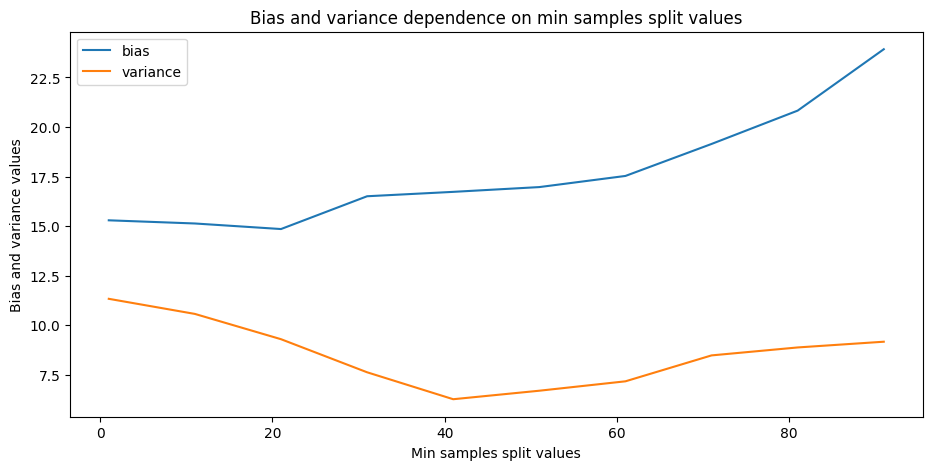

In [12]:
biases = []
variances = []
min_samples_splits = []
for i in range(1, 100, 10):
    decision_tree = MyDecisionTreeRegressor(max_depth=8, min_samples_split=i)
    bias, variance = get_bias_variance(decision_tree, X_train, y_train, 20)
    biases.append(bias)
    variances.append(variance)
    min_samples_splits.append(i)
plt.plot(min_samples_splits, biases, label='bias')
plt.plot(min_samples_splits, variances, label='variance')
plt.legend()
plt.xlabel('Min samples split values')
plt.ylabel('Bias and variance values')
plt.title('Bias and variance dependence on min samples split values')

min_samples_split - это минимальное количество элементов, необходимое для разделения узла.
Чем больше данный параметр, тем меньше дерево разрастается, тем меньше модель обучается.
На графике видны следующие тенденции:bias возрастает, variance постепенно уменьшается,
что свидетельствует о том, что модель становится меньше склонна к переобучению.

### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance. 

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments? 
 - Do your results align with the theory? Why?

In [13]:
from sklearn.ensemble import BaggingRegressor

bagging_tree = BaggingRegressor(MyDecisionTreeRegressor(max_depth=8, min_samples_split=15), n_estimators=10)
bias, variance = get_bias_variance(bagging_tree, X_train, y_train, 10)
print('Bias - ', bias)
print('Variance - ', variance)

Bias -  13.377708096571897
Variance -  1.9858010288566668


1) Бэггинг никак не влияет на смещение и уменьшает дисперсию.
2) Судя по полученным показателям, Bias для одного дерева не существенно изменяется
при бэггинге, в то время как Variance после бэггинга становится значительно меньше
3) Полученные результаты соответствуют предположениям, основанным на теоретических
знаниях, уменьшение дисперсии происходит за счет того, что мы обучаемся на нескольких выборках
с рандомным набором элементов из первоначальной выборки (с возвращением), получаем на выходе
несколько обученных моделей, а затем усредняем их предсказания. чтобы получить итоговый результат.

# Part 2. More Ensembles

In this part we will be working with [Thyroid Disease Data Set](https://archive.ics.uci.edu/ml/datasets/thyroid+disease) to solve a classification task. 

In [4]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('thyroid_disease.csv')

le = LabelEncoder()
y = le.fit_transform(df['Class'])
X = df.drop('Class', axis=1)
X.head(5)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source
0,41.0,F,f,f,f,f,f,f,f,f,...,2.5,t,125.0,t,1.14,t,109.0,f,NaN,SVHC
1,23.0,F,f,f,f,f,f,f,f,f,...,2.0,t,102.0,f,NaN,f,NaN,f,NaN,other
2,46.0,M,f,f,f,f,f,f,f,f,...,NaN,t,109.0,t,0.91,t,120.0,f,NaN,other
3,70.0,F,t,f,f,f,f,f,f,f,...,1.9,t,175.0,f,NaN,f,NaN,f,NaN,other
4,70.0,F,f,f,f,f,f,f,f,f,...,1.2,t,61.0,t,0.87,t,70.0,f,NaN,SVI


### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing. 

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice. 
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding
    - Numeric: Fill missing values
    
Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transform1, column_names1),
    ('name2', transform2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer. 
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values. 

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset. 

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
print('Shape - ', X.shape)
X.isna().sum(axis=0)

Shape -  (3772, 29)


age                             1
sex                           150
on_thyroxine                    0
query_on_thyroxine              0
on_antithyroid_medication       0
sick                            0
pregnant                        0
thyroid_surgery                 0
I131_treatment                  0
query_hypothyroid               0
query_hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH_measured                    0
TSH                           369
T3_measured                     0
T3                            769
TT4_measured                    0
TT4                           231
T4U_measured                    0
T4U                           387
FTI_measured                    0
FTI                           385
TBG_measured                    0
TBG                          3772
referral_source                 0
dtype: int64

Видно, что колонка TBG содержит только Nan-значения, следовательно, ее необходимо удалить.

In [16]:
X = X.drop('TBG', axis=1)
X.isna().sum(axis=0)

age                            1
sex                          150
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
sick                           0
pregnant                       0
thyroid_surgery                0
I131_treatment                 0
query_hypothyroid              0
query_hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH_measured                   0
TSH                          369
T3_measured                    0
T3                           769
TT4_measured                   0
TT4                          231
T4U_measured                   0
T4U                          387
FTI_measured                   0
FTI                          385
TBG_measured                   0
referral_source                0
dtype: int64

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25, 
                                                    random_state=42)

In [18]:
categorical_variables = list(X.dtypes[X.dtypes == "object"].index)
numerical_variables = list(X.dtypes[X.dtypes == "float64"].index)

pipeline = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder())
# define column_transformer 
column_transformer = ColumnTransformer(transformers=
        [('categorical_variables', pipeline, categorical_variables), ('numerical_variables', SimpleImputer(), numerical_variables)])
# Transform the data
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

### Task 2 <a id="task2_2"></a> (0.7 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [19]:
df['Class'].value_counts()

negative    3541
sick         231
Name: Class, dtype: int64

In [20]:
if  df['Class'].value_counts()['negative'] == df['Class'].value_counts()['sick']:
    print('Classes are balanced')
else:
    print('Classes are not balanced')

Classes are not balanced


In [21]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [37]:
gradient_boosting = GradientBoostingClassifier()
cv_gradient_boosting = \
    cross_validate(gradient_boosting, X_train, y_train, scoring="f1", cv=StratifiedKFold(n_splits=5), return_train_score=True)
print('Gradient boosting train score', cv_gradient_boosting["train_score"].mean())
print('Gradient boosting test score', cv_gradient_boosting["test_score"].mean())

Gradient boosting train score 0.9951412750657413
Gradient boosting test score 0.8795891690009338


In [23]:
random_forest = RandomForestClassifier()
cv_random_forest = cross_validate(random_forest, X_train, y_train, scoring="f1", cv=StratifiedKFold(n_splits=5), return_train_score=True)
print('Random forest train score', cv_random_forest["train_score"].mean())
print('Random forest test score', cv_random_forest["test_score"].mean())

Random forest train score 1.0
Random forest test score 0.8383723863201477


In [24]:
decision_tree = DecisionTreeClassifier(max_depth=8, min_samples_split=15)
cv_decision_tree = cross_validate(decision_tree, X_train, y_train, scoring="f1", cv=StratifiedKFold(n_splits=5), return_train_score=True)
print('Decision tree train score', cv_decision_tree["train_score"].mean())
print('Decision tree test score', cv_decision_tree["test_score"].mean())

Decision tree train score 0.9530432668789173
Decision tree test score 0.8831865943133549


In [25]:
svm = SVC(kernel="poly", degree=15)
cv_svc = cross_validate(svm, X_train, y_train, scoring="f1", cv=StratifiedKFold(n_splits=5), return_train_score=True)
print('SVM train score', cv_svc["train_score"].mean())
print('SVM test score', cv_svc["test_score"].mean())

SVM train score 0.17469000036151278
SVM test score 0.07716446533236096


In [26]:
logistic_regression = LogisticRegression()
cv_logistic_regression = cross_validate(logistic_regression, X_train, y_train, scoring="f1", cv=StratifiedKFold(n_splits=5), return_train_score=True)
print('Logistic regression train score', cv_logistic_regression["train_score"].mean())
print('Logistic regression test score', cv_logistic_regression["test_score"].mean())

Logistic regression train score 0.7068668052516875
Logistic regression test score 0.6617738491065877


1) Так как классы сильно не сбалансированны необходимо выбрать такие
метрики, которые лучше всего подходят для оценки работы модели, обученной
на несбалансированных данных. Метрика Accuracy бесполезна в случае с несба-
лансированными классами, поэтому лучше всего использовать метрику f1-score,
которая отражает среднее гармоническое между метриками precision и recall.
2) В качестве CV стратегии лучше всего использовать StratfiedKFold, так как
при таком подходе при разделении на несколько выборок в каждой выборке сохраняется
процентное соотношение классов
3) Лучшие результаты показала модель Decision tree, модель SVM недообучена и не
способна решать поставленную задачу. Модель Random Forest на тренировочных данных
показала слишком хороший результат, что может свидетельствовать о ее переобученности.

### Task 3 <a id="task2_3"></a> (0.5 points)

More Gradient Boosting. You will have to implement one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task. 

To get method that you have to implement, run cell below and input your name in Russian (for example, if you input Андрей, you will see that user with this name should implement xgboost)

In [27]:
def assign_method():
    name = input()
    methods = ['xgboost', 'lightgbm', 'catboost']
    idx = sum([ord(x) for x in list(name)]) % 3
    print('Реализуйте', methods[idx])
    
assign_method()

Реализуйте catboost


In [28]:
!pip install catboost --quiet
from catboost import CatBoostClassifier

clf = CatBoostClassifier(logging_level='Silent')
parameters = {'num_trees':range(10, 100, 10), 'learning_rate':[0.1, 0.01, 0.001], 'max_depth':range(1, 11)}
grid_cat = GridSearchCV(clf, scoring="f1", param_grid=parameters, cv=StratifiedKFold(n_splits=5))
grid_cat.fit(X_train, y_train)
train_prediction = grid_cat.predict(X_train)
print('Train score', f1_score(y_train, train_prediction))
test_prediction = grid_cat.predict(X_test)
print('Test score', f1_score(y_test, test_prediction))


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Train score 1.0
Test score 0.9108910891089109


Данная реализация бустинга показала наилучшие результаты по сравнению с
методами из предыдущих заданий.

### Task 4 <a id="task2_4"></a> (0.7 points)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting (with large amount of trees, >100) as base estimators
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) 
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees? 
* What is the difference between voting and staking? 

In [29]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier

In [30]:
bagging_with_tree = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10)
cv_bagging_with_tree = cross_validate(bagging_with_tree, X_train, y_train, scoring="f1", cv=StratifiedKFold(n_splits=5), return_train_score=True)
print('Bagging with tree train score', cv_bagging_with_tree["train_score"].mean())
print('Bagging with tree test score', cv_bagging_with_tree["test_score"].mean())

Bagging with tree train score 0.98878115884709
Bagging with tree test score 0.8625362872421697


In [31]:
bagging_with_boosting = BaggingClassifier(base_estimator=GradientBoostingClassifier(n_estimators=1000))
cv_bagging_with_boosting = cross_validate(bagging_with_boosting, X_train, y_train, scoring="f1", cv=StratifiedKFold(n_splits=5), return_train_score=True)
print('Bagging with boosting train score', cv_bagging_with_boosting["train_score"].mean())
print('Bagging with boosting test score', cv_bagging_with_boosting["test_score"].mean())

Bagging with boosting train score 0.9958477177213008
Bagging with boosting test score 0.8598558783236416


In [32]:
estimator_voting = []
estimator_voting.append(('LR',
                  LogisticRegression()))
estimator_voting.append(('DTC', DecisionTreeClassifier()))
voting = VotingClassifier(estimators=estimator_voting, voting='hard')
cv_voting = cross_validate(voting, X_train, y_train, scoring="f1", cv=StratifiedKFold(n_splits=5), return_train_score=True)
print('Voting train score', cv_voting["train_score"].mean())
print('Voting test score', cv_voting["test_score"].mean())

Voting train score 0.753565738730374
Voting test score 0.6730537632251441


In [33]:
from sklearn.ensemble import StackingClassifier

estimator_stacking = []
estimator_stacking.append(('GB',
                  GradientBoostingClassifier()))
estimator_stacking.append(('DTC', DecisionTreeClassifier()))
log = LogisticRegression()
stacking_log = StackingClassifier(estimators=estimator_stacking, final_estimator=log)
cv_stacking_log = cross_validate(stacking_log, X_train, y_train, scoring="f1", cv=StratifiedKFold(n_splits=5), return_train_score=True)
print('Stacking with logistic regression as final train score',cv_stacking_log["train_score"].mean())
print('Stacking with logistic regression as final test score', cv_stacking_log["test_score"].mean())

Stacking with logistic regression as final train score 0.9986159169550174
Stacking with logistic regression as final test score 0.8824540250882962


In [34]:
estimator_stacking = []
estimator_stacking.append(('LR',
                  LogisticRegression()))
estimator_stacking.append(('DTC', DecisionTreeClassifier()))
boosting = GradientBoostingClassifier()
stacking_boosting = StackingClassifier(estimators=estimator_stacking, final_estimator=boosting)
cv_stacking_boosting = cross_validate(stacking_boosting, X_train, y_train, scoring="f1", cv=StratifiedKFold(n_splits=5), return_train_score=True)
print('Stacking with gradient boosting as final train score', cv_stacking_boosting["train_score"].mean())
print('Stacking with gradient boosting as final test score', cv_stacking_boosting["test_score"].mean())

Stacking with gradient boosting as final train score 0.9048009555810517
Stacking with gradient boosting as final test score 0.8456464866752945


1) Наилучшие результаты показала модель Stacking с логистической регрессией
2) Бэггинг не повлиял на результаты градиентного бустинга, показатели остались
примерно на том же уровне
3) Voting: обучаем несколько моделей на нашей выборке, делаем предсказания
Результат определяется по наибольшему количеству голосов (предсказаний) моделей
Stacking: Обучаем несколько разных моделей на тренировочных данных, получаем их предсказания.
Предсказания моделей используем в качестве признака для обучения финальной модели.


### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train. 

In [35]:
estimator_stacking = []
estimator_stacking.append(('GB',
                  GradientBoostingClassifier()))
estimator_stacking.append(('DTC', DecisionTreeClassifier()))
log = LogisticRegression()
stacking_log = StackingClassifier(estimators=estimator_stacking, final_estimator=log)
stacking_log.fit(X_train, y_train)
y_prediction = stacking_log.predict(X_test)
print('Test score', f1_score(y_test, y_prediction))

Test score 0.8775510204081632
